# Gesture Recognition
### Build a Model to recognise five different gestures performed by the user.

>### Thumbs up: Increase the volume
>### Thumbs down: Decrease the volume
>### Left swipe: 'Jump' backwards 10 seconds
>### Right swipe: 'Jump' forward 10 seconds
>### Stop: Pause the movie

## Data Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/Gesture/Project_data.zip /content
filename = '/content/drive/MyDrive/Gesture/Project_data.zip'
import zipfile
zip_ref = zipfile.ZipFile(filename, "r")
zip_ref.extractall()
zip_ref.close()

In [3]:
import numpy as np
import os
from  skimage.transform import resize
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [5]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

In [6]:
no_of_frames =len( np.append(np.arange(0,30,step=4),29))

## Generator

In [7]:
def generator(source_path, folder_list, batch_size, image_resize_dim, img_idx, sort='no'):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx
    x, y, z = len(img_idx), *image_resize_dim
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(np.ceil(len(folder_list)/batch_size))
        for batch in range(num_batches): # we iterate over the number of batches
            # create act_batch_size to handle the remaining data points in last batch if total data points is not multiple of batch size
            if(batch == (num_batches-1)):
              act_batch_size = len(folder_list) - (batch*batch_size)
            else:
              act_batch_size = batch_size
            batch_data = np.zeros((act_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((act_batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(act_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*act_batch_size)].split(';')[0]) # read all the images in the folder
                if(sort=='yes'):
                  imgs = sorted(imgs)  # sort the images in folder for timewise sequence
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*act_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = cv2.resize(image, image_resize_dim)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255  #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*act_batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Plot Function

In [9]:
import matplotlib.pyplot as plt
model_no = 1
def plot_loss_curves(history):
  global model_no
  model_no = model_no + 1
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['categorical_accuracy']
  val_accuracy = history.history['val_categorical_accuracy']

  epochs = range(len(history.history['loss']))
  fig = plt.figure(figsize=(10, 4))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

  plt.show()

In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, SimpleRNN, LSTM
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import ResNet50

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

In [12]:
def get_steps_per_epoch(batch_size):
  if (num_train_sequences%batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1
  return steps_per_epoch, validation_steps

In [13]:
image_resize_dim=(100,100)
batch_size = 10
img_idx = np.append(np.arange(0,30,step=4),29)
train_generator = generator(train_path, train_doc, batch_size,image_resize_dim, img_idx)
val_generator = generator(val_path, val_doc, batch_size,image_resize_dim, img_idx)
steps_per_epoch, validation_steps = get_steps_per_epoch(batch_size)

## Image Processing Function

In [14]:
def image_process(p_image_resize_dim,p_batch_size):
  global image_resize_dim,batch_size,img_idx,train_generator,val_generator,steps_per_epoch, validation_steps
  image_resize_dim = p_image_resize_dim
  batch_size = p_batch_size
  img_idx = np.append(np.arange(0,30,step=4),29)
  train_generator = generator(train_path, train_doc, batch_size,image_resize_dim, img_idx)
  val_generator = generator(val_path, val_doc, batch_size,image_resize_dim, img_idx)
  steps_per_epoch, validation_steps = get_steps_per_epoch(batch_size)

# Model 1: Conv3D - 100*100 - Batch Size 10

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 7, 98, 98, 64)     5248      
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 96, 96, 64)     110656    
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 94, 94, 128)    221312    
                                                                 
 max_pooling3d (MaxPooling3  (None, 1, 47, 47, 128)    0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1, 47, 47, 128)    0         
                                                                 
 flatten (Flatten)           (None, 282752)            0         
                                                        

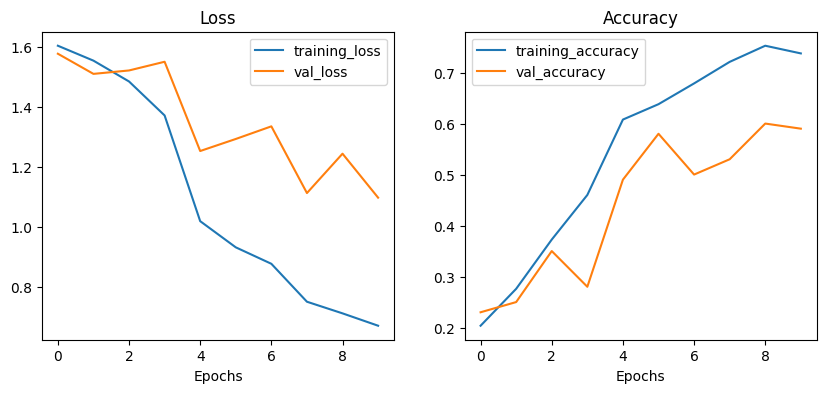

In [15]:
image_resize_dim=(100,100)


model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',  input_shape=(no_of_frames,*image_resize_dim,3)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())


model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.SGD()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience= 2, min_lr=0.001)
callbacks_list = [LR]
history1 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                      validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)
plot_loss_curves(history1)

# Model 2: Conv3D - - 100*100 - Batch Size 10 - with sort images in generator

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 7, 98, 98, 64)     5248      
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 96, 96, 64)     110656    
                                                                 
 conv3d_5 (Conv3D)           (None, 3, 94, 94, 128)    221312    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 47, 47, 128)    0         
 g3D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 1, 47, 47, 128)    0         
                                                                 
 flatten_1 (Flatten)         (None, 282752)            0         
                                                      

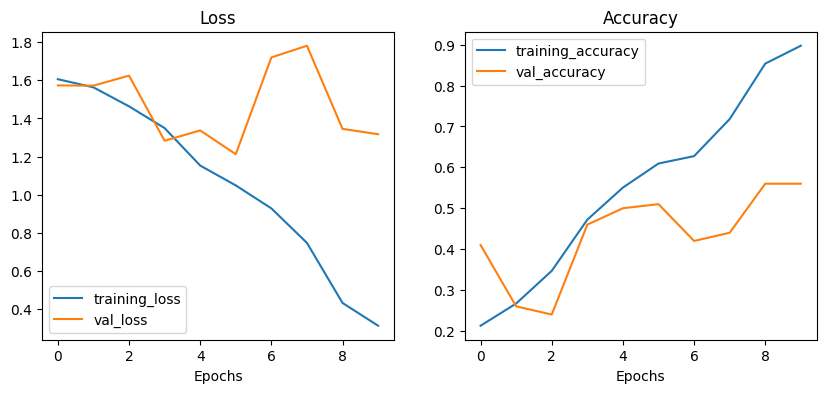

In [16]:
image_process((100,100),10)

model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',  input_shape=(no_of_frames,*image_resize_dim,3)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))

model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.SGD()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience= 2, min_lr=0.001)
callbacks_list = [ LR]
history2 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                      validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)
plot_loss_curves(history2)

# Model 3: Conv3D - - 100*100 - Batch Size 50 - with sort images in generator

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 7, 98, 98, 64)     5248      
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 96, 96, 64)     110656    
                                                                 
 conv3d_8 (Conv3D)           (None, 3, 94, 94, 128)    221312    
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 1, 47, 47, 128)    0         
 g3D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 1, 47, 47, 128)    0         
                                                                 
 flatten_2 (Flatten)         (None, 282752)            0         
                                                      

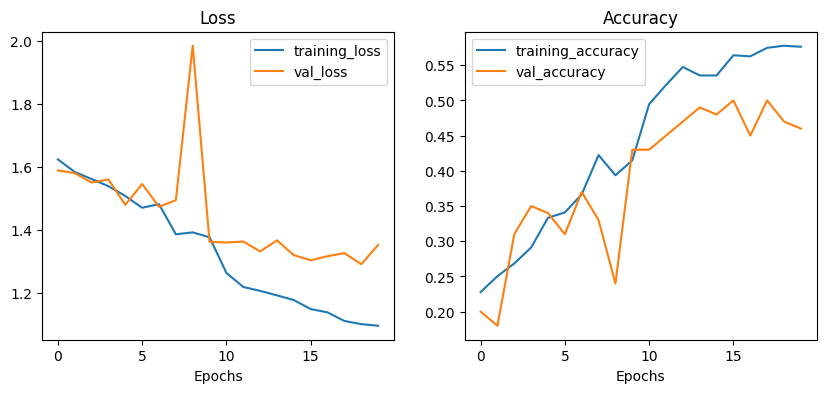

In [17]:
image_process((100,100),50)

model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',  input_shape=(no_of_frames,*image_resize_dim,3)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())


model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.SGD()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience= 2, min_lr=0.001)
callbacks_list = [ LR]
history3 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                      validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)
plot_loss_curves(history3)

# Model 4 - LSTM

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 9, 576)            24112064  
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, 9, 32)             77952     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 5)                 165       
                                                                 
Total params: 24198501 (92.31 MB)
Trainable params: 24145381 (92.11 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
None
Sour

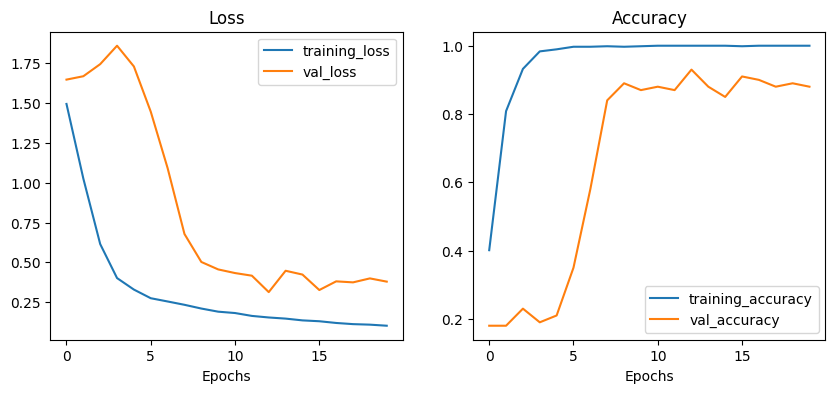

In [18]:
image_process((100,100),10)

resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(*image_resize_dim,3))
cnn =Sequential([resnet])
cnn.add(Conv2D(64,(2,2),strides=(1,1)))
cnn.add(Flatten())
lstm_model = Sequential()
lstm_model.add(TimeDistributed(cnn,input_shape=(no_of_frames,*image_resize_dim,3)))
lstm_model.add(LSTM(32,return_sequences=True))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(5,activation='softmax'))
optimiser = optimizers.SGD()
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                            patience= 2, min_lr=0.002)
lstm_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (lstm_model.summary())

history4 = lstm_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                  callbacks=[ LR], validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot_loss_curves(history4)

# Model 5: GRU

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDi  (None, 9, 576)            24112064  
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 9, 32)             58560     
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_7 (Dense)             (None, 5)                 165       
                                                                 
Total params: 24177125 (92.23 MB)
Trainable params: 24124005 (92.03 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
None
Source path =  Project_data/train ; batch size = 10
Epoch 1/20
67/67 

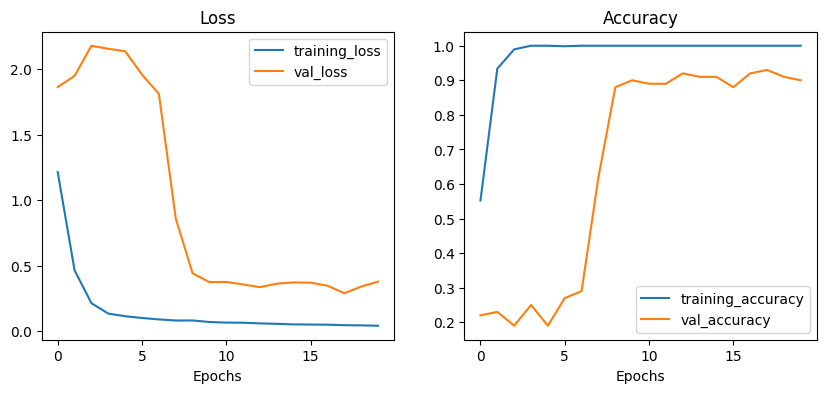

In [19]:
image_process((100,100),10)

resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(*image_resize_dim,3))
cnn =Sequential([resnet])
cnn.add(Conv2D(64,(2,2),strides=(1,1)))
cnn.add(Flatten())
gru_model = Sequential()
gru_model.add(TimeDistributed(cnn,input_shape=(no_of_frames,*image_resize_dim,3)))
gru_model.add(GRU(32,return_sequences=True))
gru_model.add(GRU(32))
gru_model.add(Dense(5,activation='softmax'))
optimiser = optimizers.SGD(learning_rate=0.008)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                            patience= 2, min_lr=0.002)
gru_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (gru_model.summary())

history5 = gru_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                  callbacks=[ LR], validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot_loss_curves(history5)

# Final Model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 9, 576)            24112064  
 stributed)                                                      
                                                                 
 simple_rnn (SimpleRNN)      (None, 9, 32)             19488     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 5)                 165       
                                                                 
Total params: 24133797 (92.06 MB)
Trainable params: 24080677 (91.86 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
None
Source path =  Project_data/train ; batch size = 10
Epoch 1/20
67/67 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 49s 438ms/step - loss: 1.0871 - categorical_accuracy: 0.6169 - val_loss: 1.9326 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.4821 - categorical_accuracy: 0.8703
Epoch 2: saving model to model_init_2024-04-2802_52_00.452597/model-00002-0.48213-0.87029-1.82629-0.19000.h5
67/67 [==============================] - 26s 393ms/step - loss: 0.4821 - categorical_accuracy: 0.8703 - val_loss: 1.8263 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.2181 - categorical_accuracy: 0.9548
Epoch 3: saving model to model_init_2024-04-2802_52_00.452597/model-00003-0.21809-0.95475-1.87279-0.19000.h5
67/67 [==============================] - 29s 429ms/step - loss: 0.2181 - categorical_accuracy: 0.9548 - val_loss: 1.8728 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 4/20
67/67 [==============================] - ETA: 0s - l

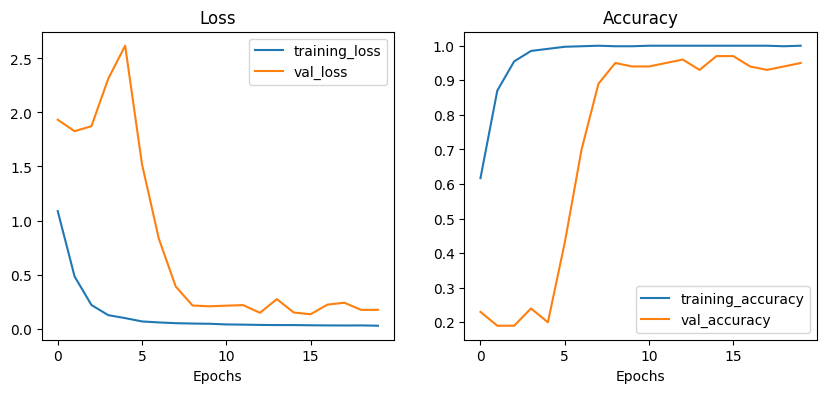

In [20]:
image_resize_dim=(100,100)
batch_size = 10
img_idx = np.append(np.arange(0,30,step=4),29)
train_generator = generator(train_path, train_doc, batch_size,image_resize_dim, img_idx, 'yes')
val_generator = generator(val_path, val_doc, batch_size,image_resize_dim, img_idx,'yes')
steps_per_epoch, validation_steps = get_steps_per_epoch(batch_size)

resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(*image_resize_dim,3))
cnn =Sequential([resnet])
cnn.add(Conv2D(64,(2,2),strides=(1,1)))
cnn.add(Flatten())
rnn_model = Sequential()
rnn_model.add(TimeDistributed(cnn,input_shape=(no_of_frames,*image_resize_dim,3)))
rnn_model.add(SimpleRNN(32,return_sequences=True))
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(5,activation='softmax'))
optimiser = optimizers.SGD()
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                            patience= 2, min_lr=0.002)
rnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (rnn_model.summary())

history7 = rnn_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                  callbacks=[ checkpoint,LR], validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot_loss_curves(history7)